# Thermography

## Libraries

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import cv2 as cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay, classification_report
from keras.preprocessing import image
from keras.models import Sequential, load_model, Model
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Dense
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## Data selection

In [3]:
class Data:
	def __init__(self, root):
		self.table = self.__generate_table(root)
		self.training, self.validation, self.test = None, None, None

	def __generate_table(self, root):
		files = []

		for category in os.listdir(root):
			for filename in os.listdir(root + category):
				files.append([root + category + "/" + filename, category])

		return pd.DataFrame(files, columns=["filename", "category"])

In [4]:
data = Data("./data/thermography/")

In [5]:
data.table.head(1)

filename category
0  ./data/thermography/healthy/16-TFRON_V16_31-10...  healthy

## Preprocessing and transformation

In [6]:
data.table.category = data.table.category.factorize()[0].astype(str)

In [7]:
data.table.head(1)

filename category
0  ./data/thermography/healthy/16-TFRON_V16_31-10...        0

In [8]:
data.training, data.test = train_test_split(data.table, test_size=0.15, shuffle=True)

In [9]:
print(f"Raw: {data.table.category.value_counts().values}")
print(f"Training: {data.training.category.value_counts().values}")
print(f"Test: {data.test.category.value_counts().values}")

Raw: [99 96]
Training: [85 80]
Test: [16 14]


In [10]:
train_datagen = image.ImageDataGenerator(
	rescale=1./255,
	validation_split=0.2
)

test_datagen = image.ImageDataGenerator(
    rescale=1./255
)

In [11]:
train_generator = train_datagen.flow_from_dataframe(
	dataframe=data.training,
    x_col="filename",
    y_col="category",
    target_size=(215, 538),
    batch_size=25,
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb",
    subset="training"
)

validation_generator = train_datagen.flow_from_dataframe(
	dataframe=data.training,
    x_col="filename",
    y_col="category",
    target_size=(215, 538),
    batch_size=25,
    class_mode="categorical",
    shuffle=True,
    color_mode="rgb",
    subset="validation"
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=data.test,
    x_col="filename",
    y_col="category",
    target_size=(215, 538),
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    color_mode="rgb",
)

Found 132 validated image filenames belonging to 2 classes.
Found 33 validated image filenames belonging to 2 classes.
Found 30 validated image filenames belonging to 2 classes.


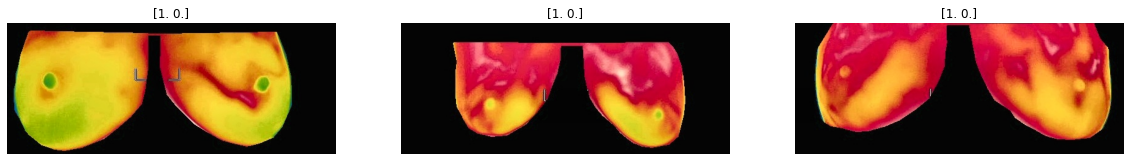

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

img, label = train_generator.next()

for i in range(3):    
    ax[i].imshow(img[i])
    ax[i].title.set_text(str(label[i]))
    ax[i].axis("off")
    
plt.show()

## Data mining

### Model creation

In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(215, 538,  3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(GlobalMaxPooling2D())

model.add(Dropout(rate=0.4))
model.add(Dense(32, activation="relu"))
model.add(Dropout(rate=0.4))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 213, 536, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 106, 268, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 104, 266, 32)      9248      
_________________________________________________________________
global_max_pooling2d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [14]:
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=0.0005), metrics=["accuracy"])

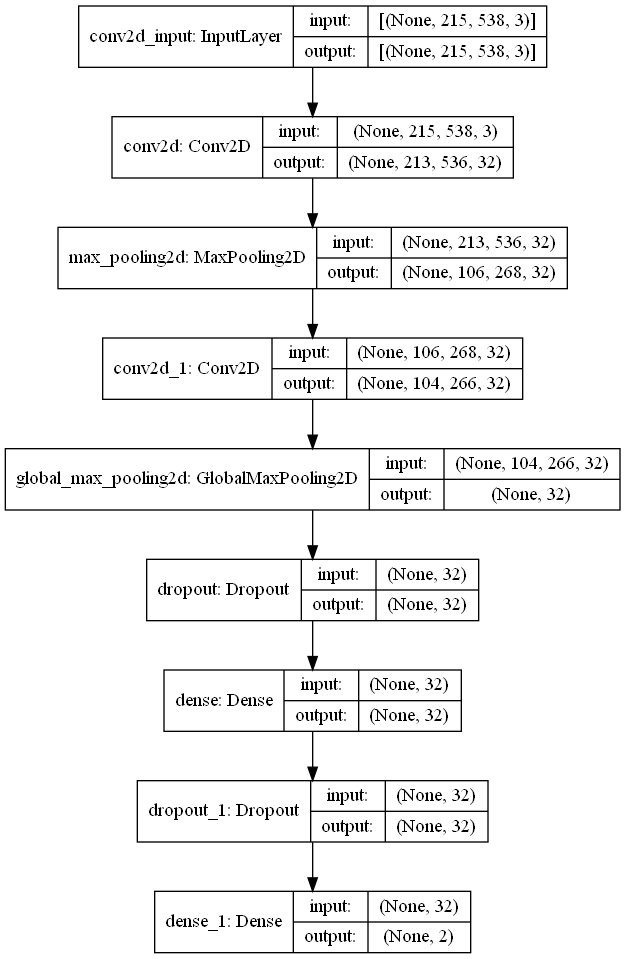

In [15]:
plot_model(model, show_shapes=True)

In [16]:
with open("./model.json", "w") as json_file:
	json_file.write(model.to_json())

In [17]:
checkpoint = ModelCheckpoint("weights/weights-{epoch:02d}.hdf5", monitor="val_accuracy", verbose=1, save_best_only=False, mode="max")

### Model training

In [ ]:
history = model.fit(train_generator, epochs=600, validation_data=validation_generator, callbacks=[checkpoint])

In [ ]:
plt.style.use("ggplot")

plt.figure()

plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()

### Model evaluation

In [18]:
model.load_weights("weights/weights-400.hdf5")

In [20]:
def evaluateModel(predict, evaluate=False):
	model.evaluate(predict)

	if evaluate:
		predictions = np.argmax(model.predict(predict), axis=-1)

		cm = confusion_matrix(predict.classes, predictions)
		display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(predict.labels))
		display = display.plot(cmap=plt.cm.Blues, xticks_rotation=0)
		plt.show()

		print(classification_report(predict.classes, predictions))

		TP = cm[1][1]
		TN = cm[0][0]
		FP = cm[0][1]
		FN = cm[1][0]

		accuracy = (float(TP + TN) / float(TP + TN + FP + FN))
		print("Accuracy:", round(accuracy,4))

		specificity = (TN / float(TN + FP))
		print("Specificity:", round(specificity, 4))

		sensitivity = (TP / float(TP + FN))
		print("Sensitivity:", round(sensitivity, 4))

		precision = (TP / float(TP + FP))
		print("Precision:", round(precision, 4))

6/6 [==============================] - 3s 384ms/step - loss: 0.1308 - accuracy: 0.9470


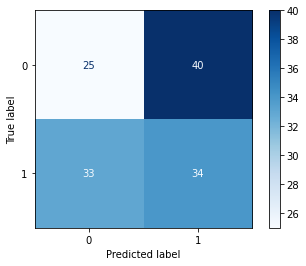

              precision    recall  f1-score   support

           0       0.43      0.38      0.41        65
           1       0.46      0.51      0.48        67

    accuracy                           0.45       132
   macro avg       0.45      0.45      0.44       132
weighted avg       0.45      0.45      0.44       132

Accuracy: 0.447
Specificity: 0.3846
Sensitivity: 0.5075
Precision: 0.4595


In [21]:
evaluateModel(train_generator, True)

2/2 [==============================] - 1s 181ms/step - loss: 0.1299 - accuracy: 0.9697


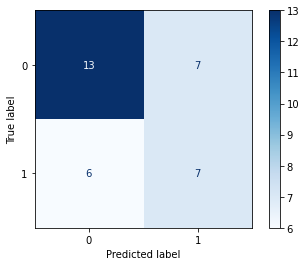

              precision    recall  f1-score   support

           0       0.68      0.65      0.67        20
           1       0.50      0.54      0.52        13

    accuracy                           0.61        33
   macro avg       0.59      0.59      0.59        33
weighted avg       0.61      0.61      0.61        33

Accuracy: 0.6061
Specificity: 0.65
Sensitivity: 0.5385
Precision: 0.5


In [22]:
evaluateModel(validation_generator, True)

30/30 [==============================] - 1s 23ms/step - loss: 0.0792 - accuracy: 1.0000


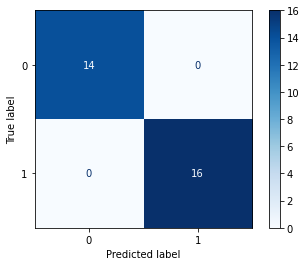

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        16

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

Accuracy: 1.0
Specificity: 1.0
Sensitivity: 1.0
Precision: 1.0


In [23]:
evaluateModel(test_generator, True)

In [38]:
def get_gradcam_heatmap(path, model, prediction_index=None):
	for idx in range(len(model.layers)):
		if (idx == 2):
			conv_output_name = model.get_layer(index=idx).name

	grad_model = Model([model.input], [model.get_layer(conv_output_name).output, model.output])

	with tf.GradientTape() as tape:
		conv_output, predictions = grad_model(path)

		if prediction_index is None:
			prediction_index = np.argmax(predictions[0])

		class_channel = predictions[:, 1]

	grads = tape.gradient(class_channel, conv_output)
	pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

	conv_output = conv_output[0]
	
	heatmap = conv_output @ pooled_grads[..., tf.newaxis]
	heatmap = tf.squeeze(heatmap)
	heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

	return heatmap.numpy()

def save_gradcam(path, heatmap, title):
	img = image.load_img(path, color_mode="grayscale")
	img = image.img_to_array(img)

	heatmap = np.uint8(255 * heatmap)
	jet = cm.get_cmap("jet")
	jet_colors = jet(np.arange(256))[:, :3]
	jet_heatmap = jet_colors[heatmap]
	jet_heatmap = image.array_to_img(jet_heatmap)
	jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
	jet_heatmap = image.img_to_array(jet_heatmap)

	superimposed_img = jet_heatmap * 0.4 + img
	superimposed_img = image.array_to_img(superimposed_img)

	fig, ax = plt.subplots(1, 3, figsize=(20, 8))

	ax[0].imshow(cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB))
	ax[1].imshow(superimposed_img)
	ax[2].imshow(image.array_to_img(jet_heatmap))

	fig.suptitle(title)
	plt.subplots_adjust(top=1.3)

	if not os.path.isdir("results/"):
		os.makedirs("results/")

	plt.savefig("results/" + os.path.basename(path), bbox_inches="tight")
	
	plt.show()

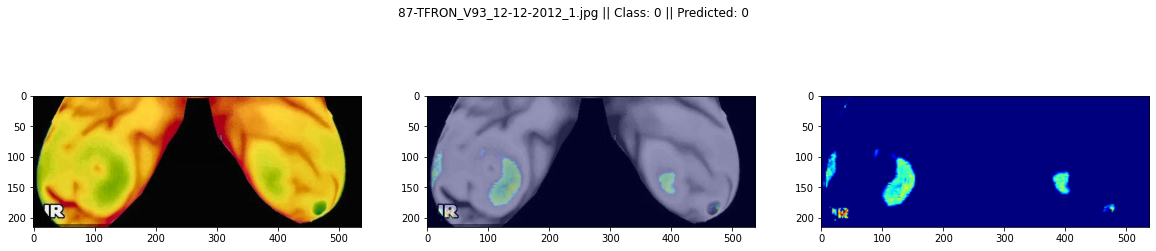

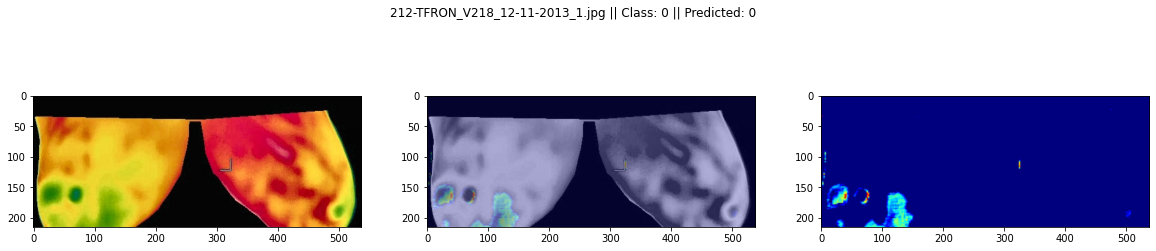

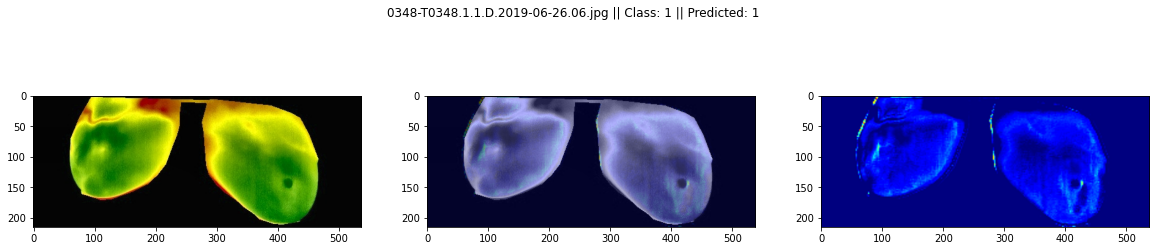

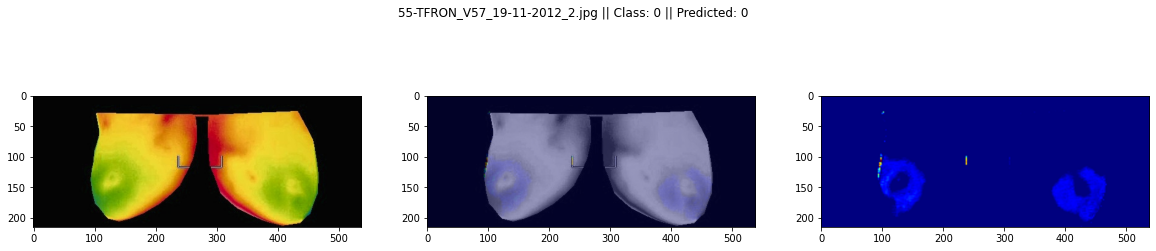

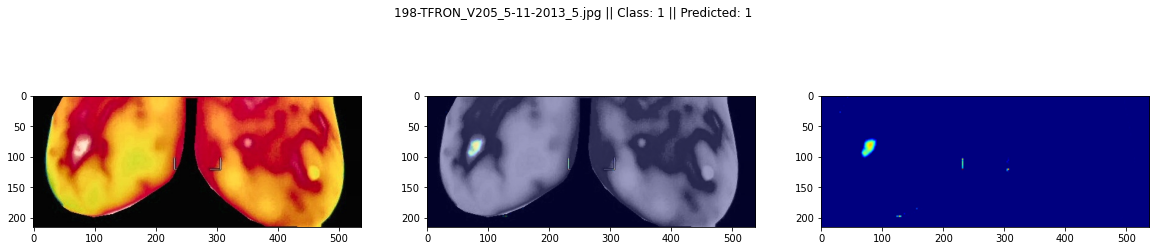

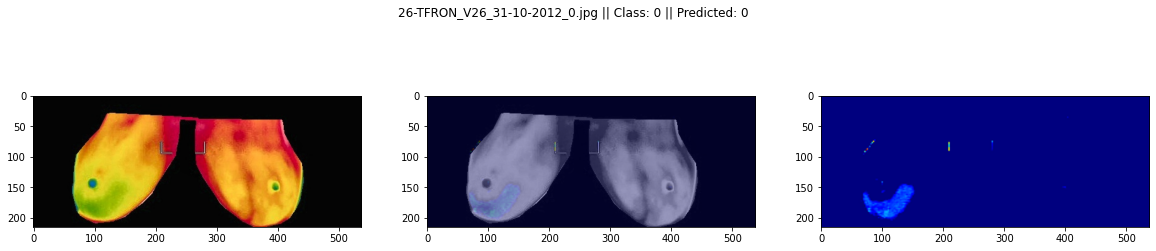

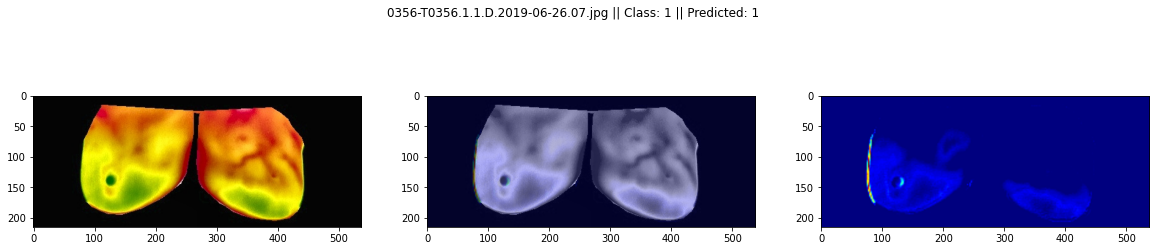

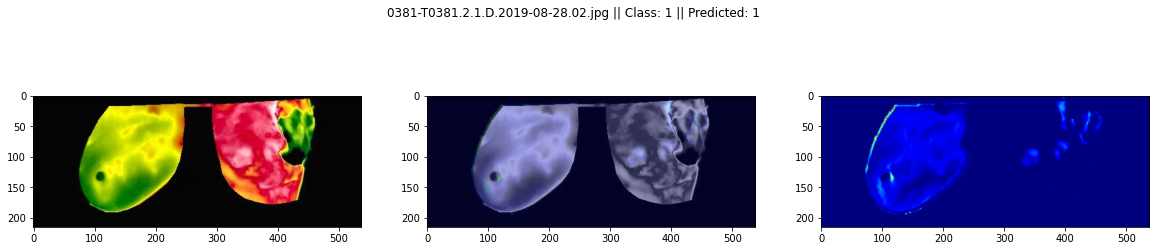

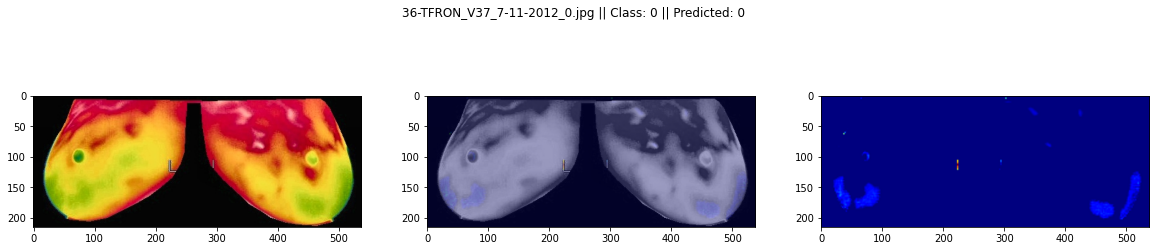

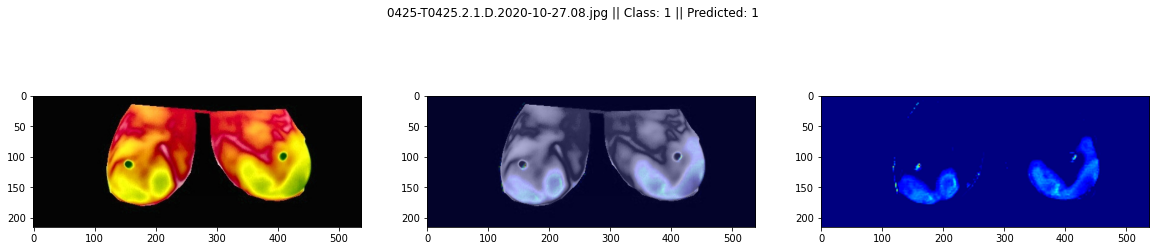

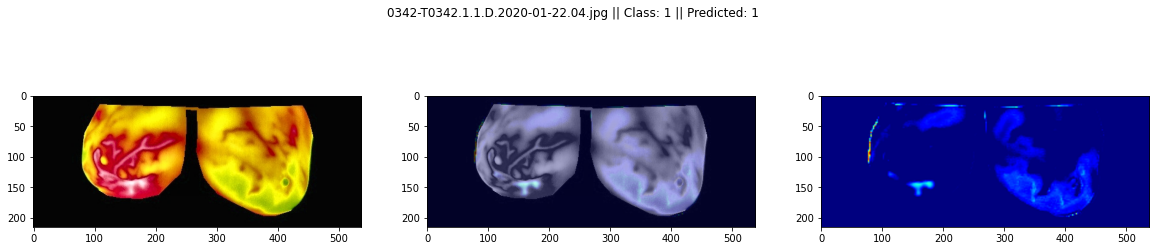

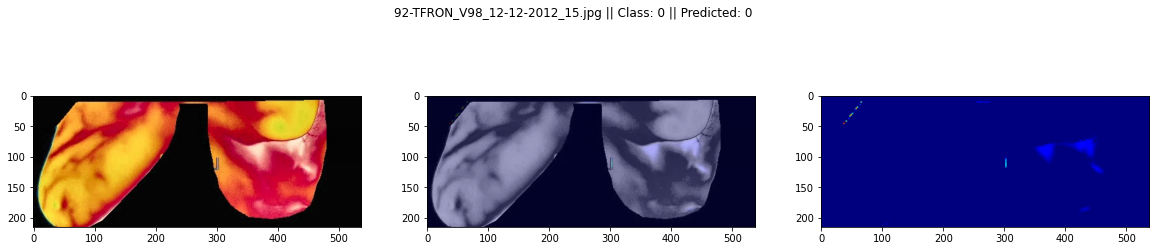

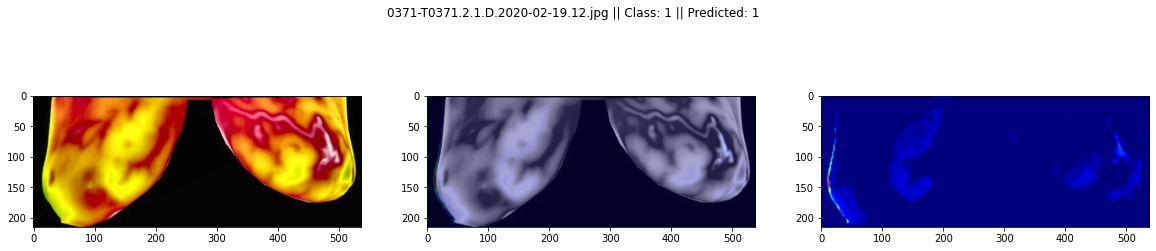

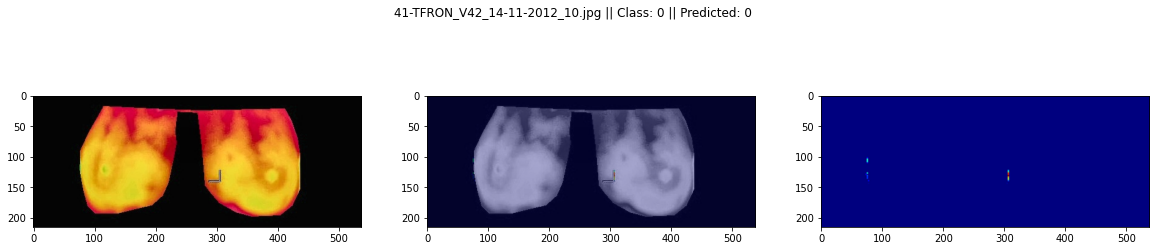

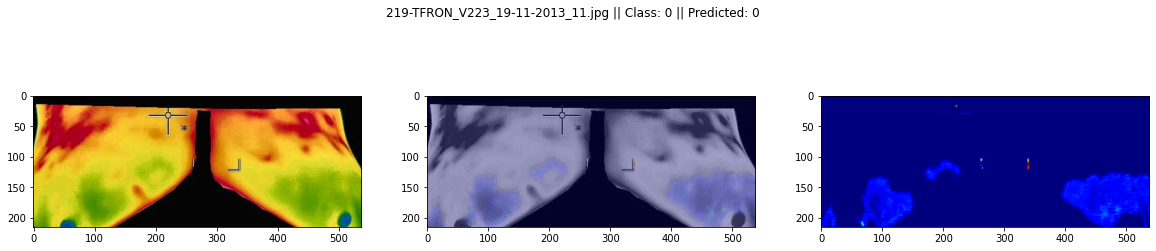

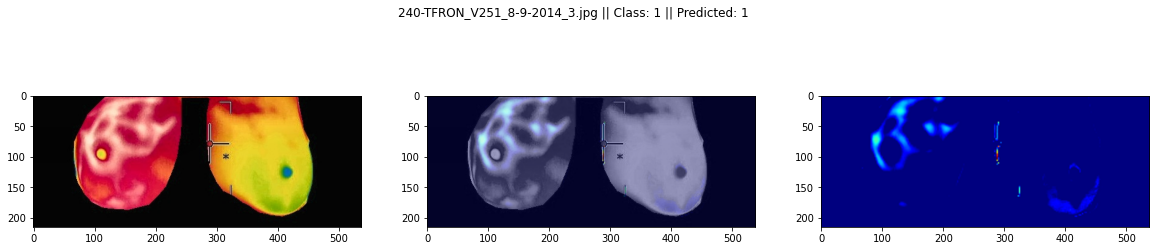

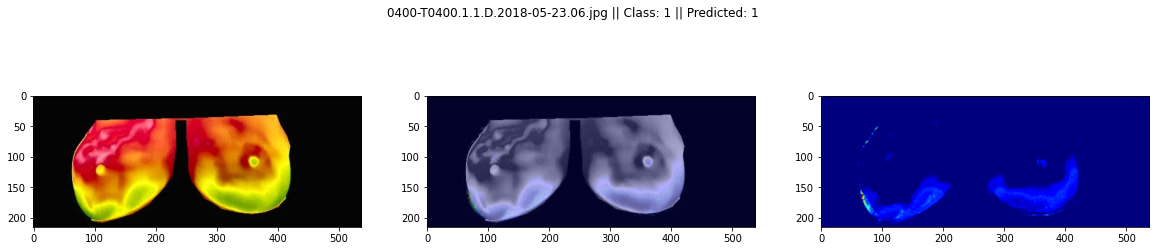

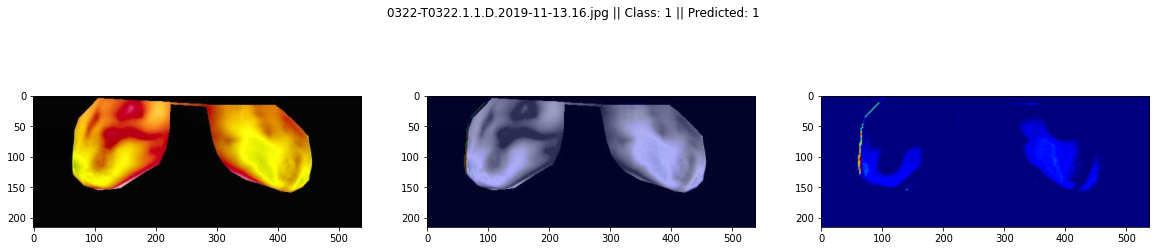

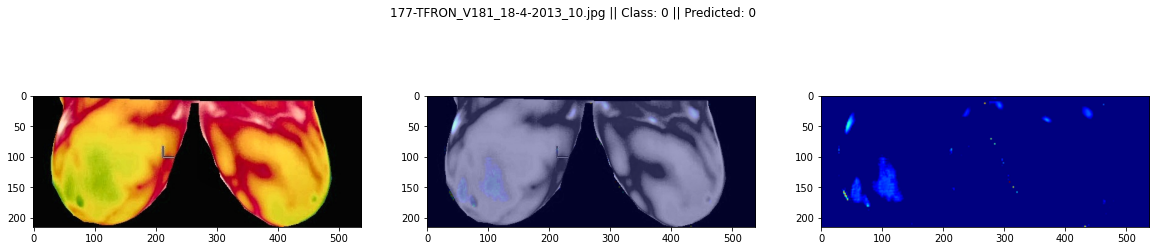

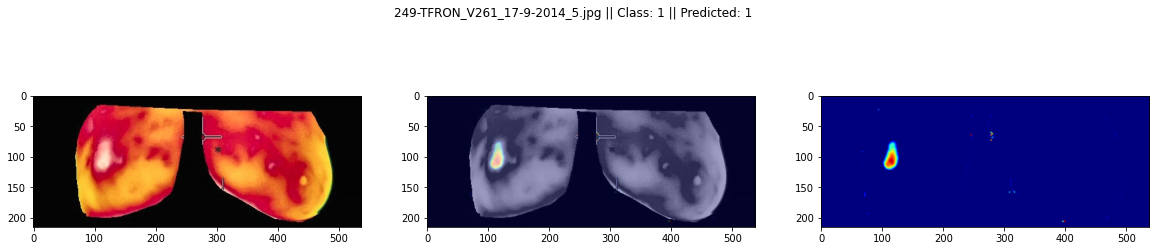

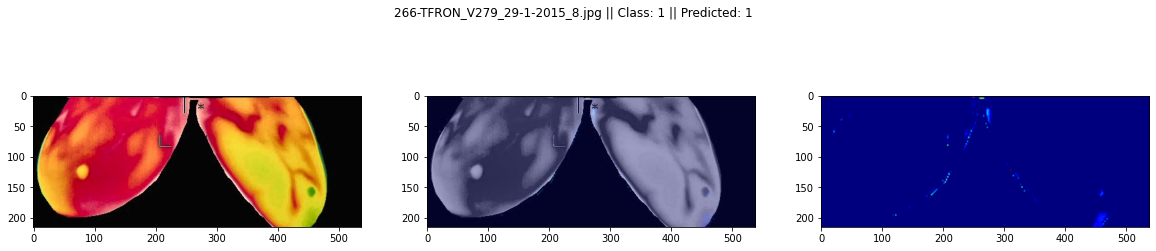

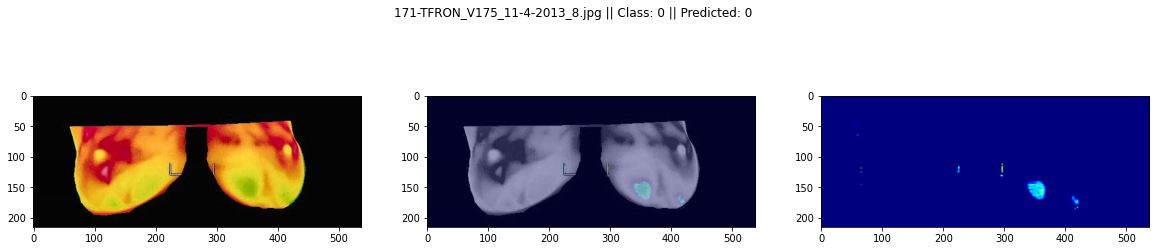

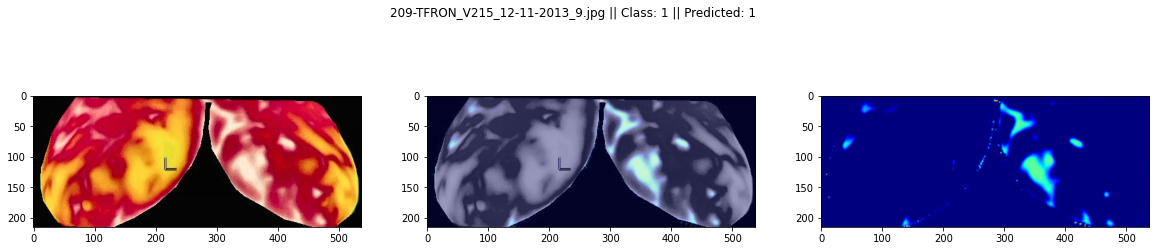

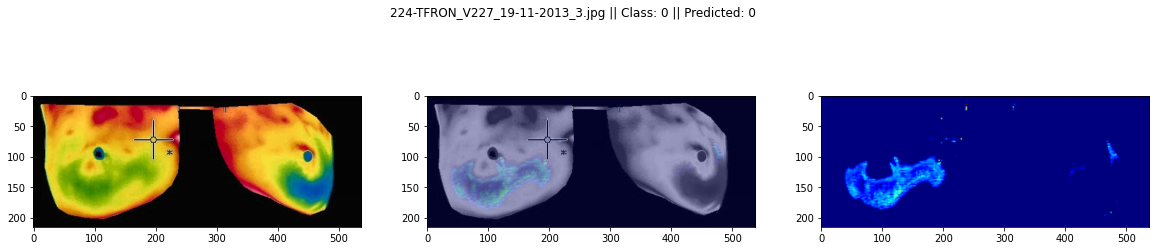

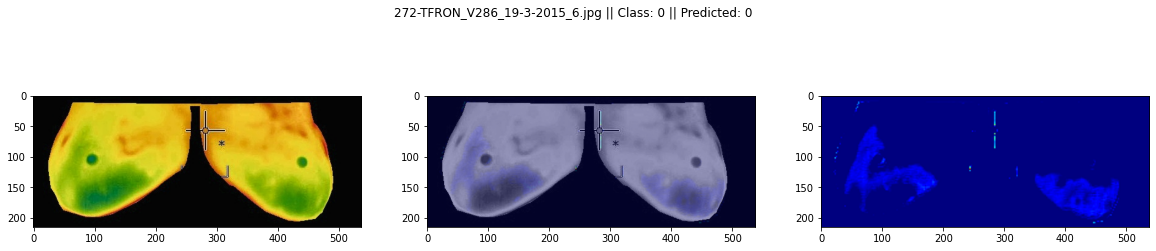

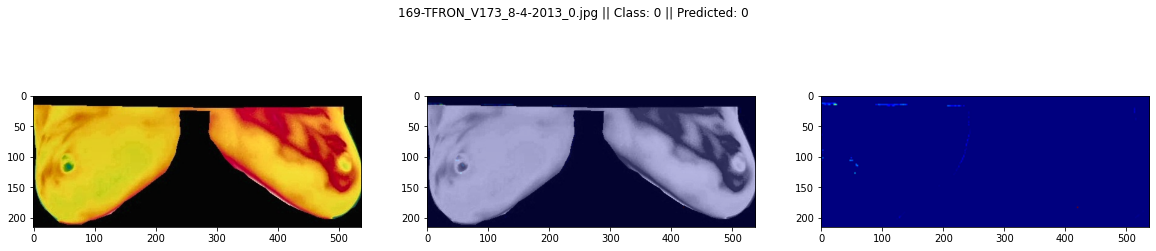

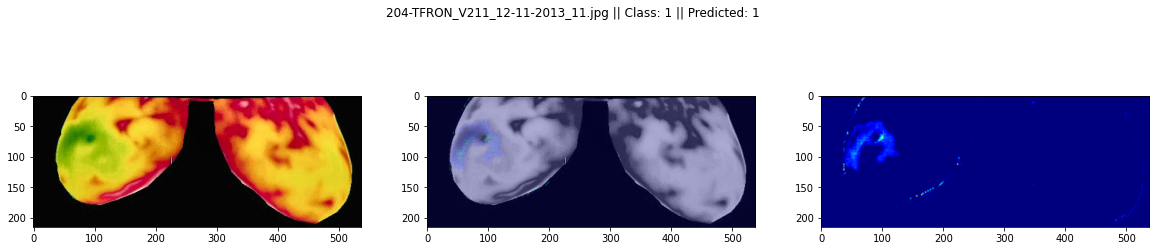

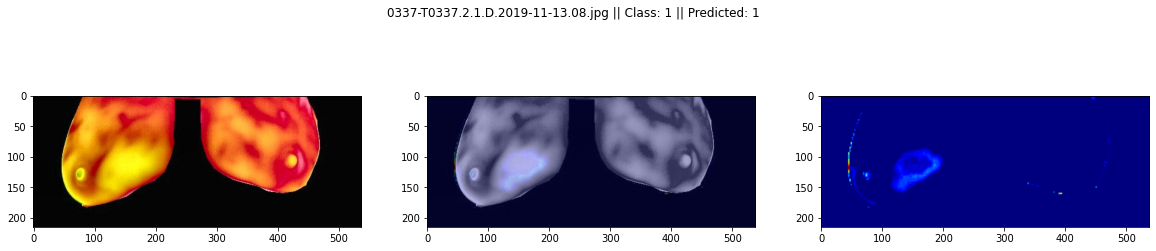

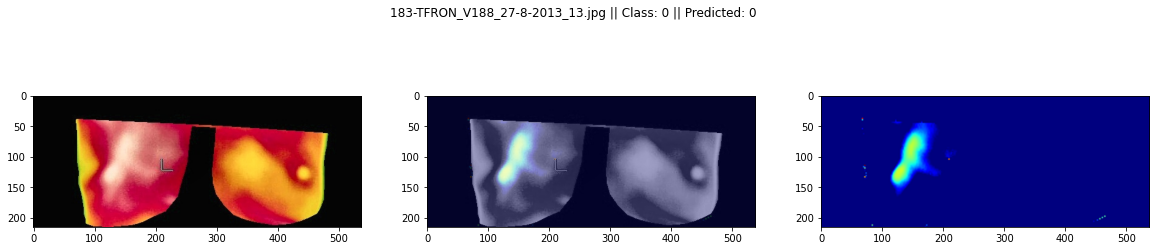

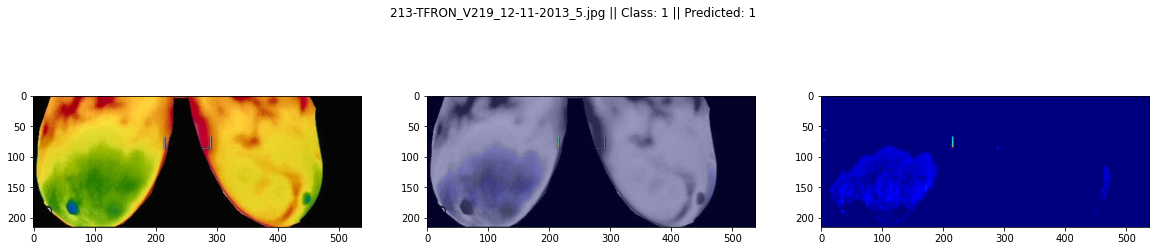

In [40]:
for index, test_image in data.test.iterrows():
	img = cv.cvtColor(cv.imread(test_image.filename), cv.COLOR_BGR2RGB)
	img = cv.resize(img, (538, 215))
	img = img.astype("float32") * 1./255
	img = np.expand_dims(img, axis=0)

	predicted = np.argmax(model.predict(img)[0])

	heatmap = get_gradcam_heatmap(img, model, predicted)
	title = os.path.basename(test_image.filename) + " || " + "Class: " + test_image.category + " || " + "Predicted: " + str(predicted)

	save_gradcam(test_image.filename, heatmap, title)